# BrainHemNet: Automated Intracranial Hemorrhage Detection and Segmentation using DINOv3 and SAM2

In [4]:
# First, install all required packages
!pip install torch torchvision monai scikit-learn opencv-python matplotlib tqdm pandas
!pip install transformers  # For DINOv3
!pip install git+https://github.com/facebookresearch/sam2.git  # Install SAM2 directly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 86.4 MB/s eta 0:00:00
  Attempting uninstall: nvi

Using device: cuda
DINOv3 transformers imported successfully
SAM2 imported successfully
Setting up models...
Loading DINOv3 model...
DINOv3 model loaded successfully
Loading SAM2 model...
SAM2 model loaded successfully from Hugging Face
Found 1000 valid training images out of 1000 total
Extracting features from training data...


Extracting features: 100%|██████████| 250/250 [01:05<00:00,  3.83it/s]


Training anomaly detector...
Testing on sample image: ID_27a354d42.dcm


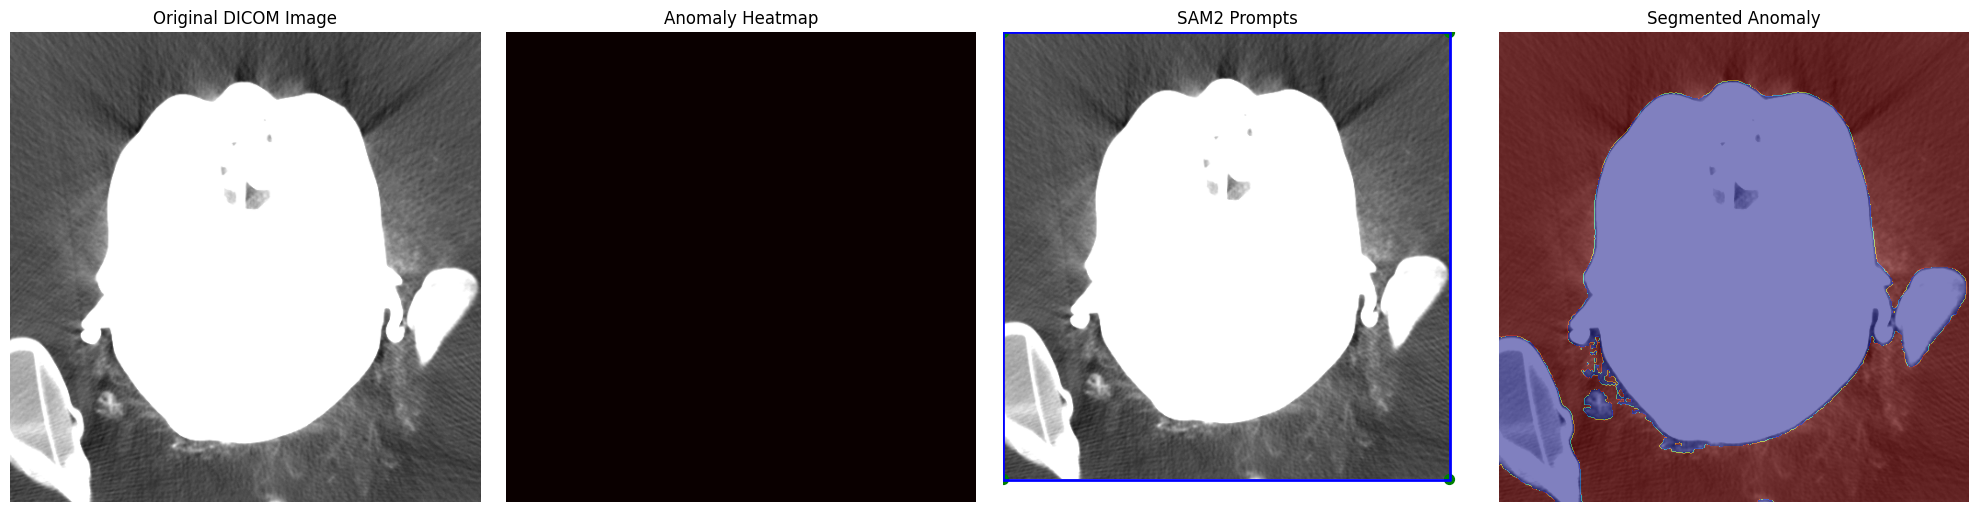

Pipeline completed successfully!


In [4]:
# Import all necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import pydicom  # For DICOM file reading
import monai
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Import DINOv3 from transformers
try:
    from transformers import AutoImageProcessor, AutoModel
    dinov3_available = True
    print("DINOv3 transformers imported successfully")
except ImportError:
    print("Transformers library not available.")
    dinov3_available = False

# Import SAM2 
try:
    from sam2.build_sam import build_sam2
    from sam2.sam2_image_predictor import SAM2ImagePredictor
    sam2_available = True
    print("SAM2 imported successfully")
except ImportError as e:
    print(f"SAM2 import failed: {e}")
    sam2_available = False

# Configuration
class Config:
    # Data paths (update these based on your Kaggle dataset structure)
    train_csv_path = "/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv"
    train_image_dir = "/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train"
    test_image_dir = "/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test"
    
    # Model parameters
    image_size = 512
    dinov3_model_name = "facebook/dinov2-base"  # Using DINOv2 which works better with transformers
    
    # Training parameters
    batch_size = 4  # Reduced for Kaggle memory constraints
    learning_rate = 1e-4
    num_epochs = 5   # Reduced for Kaggle time constraints
    
    # Anomaly detection parameters
    anomaly_threshold = 0.7
    num_components = 5  # Reduced for Kaggle memory constraints
    
    # Medical image specific parameters
    window_center = 40    # Typical brain window center
    window_width = 80     # Typical brain window width
    use_windowing = True  # Apply medical image windowing

config = Config()

# Enhanced DICOM reading functions
def apply_windowing(image, window_center, window_width):
    """Apply medical image windowing to 16-bit DICOM images"""
    window_min = window_center - window_width / 2
    window_max = window_center + window_width / 2
    
    # Clip values to window range
    image = np.clip(image, window_min, window_max)
    
    # Scale to 0-255
    image = ((image - window_min) / (window_max - window_min + 1e-8) * 255).astype(np.uint8)
    
    return image

def read_dicom_image(dicom_path):
    try:
        # Read DICOM file
        dicom = pydicom.dcmread(dicom_path)
        
        # Extract pixel array
        img_array = dicom.pixel_array
        
        # Handle specific problematic format: (1, 1, 3), <i2
        if img_array.shape == (1, 1, 3) and (img_array.dtype == np.int16 or img_array.dtype == np.uint16):
            # This appears to be a single pixel with RGB values
            # Extract the RGB values and create a solid color image
            rgb_values = img_array[0, 0]
            # Create a 256x256 image with the same color
            img_array = np.full((256, 256, 3), rgb_values, dtype=np.uint8)
            image = Image.fromarray(img_array)
            return image
        
        # Handle other unusual shapes
        if len(img_array.shape) == 3 and img_array.shape[2] == 3 and img_array.shape[0] == 1 and img_array.shape[1] == 1:
            # Single pixel RGB image - expand to reasonable size
            rgb_values = img_array[0, 0]
            img_array = np.full((256, 256, 3), rgb_values, dtype=np.uint8)
            image = Image.fromarray(img_array)
            return image
        
        # Convert 16-bit to 8-bit if necessary with medical windowing
        if img_array.dtype == np.uint16 or img_array.dtype == np.int16:
            # Use windowing for medical images
            window_center = getattr(dicom, 'WindowCenter', config.window_center)
            window_width = getattr(dicom, 'WindowWidth', config.window_width)
            
            if hasattr(window_center, '__iter__') and not isinstance(window_center, str):
                window_center = window_center[0] if len(window_center) > 0 else config.window_center
            if hasattr(window_width, '__iter__') and not isinstance(window_width, str):
                window_width = window_width[0] if len(window_width) > 0 else config.window_width
            
            # Apply windowing
            img_array = apply_windowing(img_array.astype(np.float32), float(window_center), float(window_width))
        
        # Handle single channel images
        if len(img_array.shape) == 2:
            # Convert to 3-channel
            img_array = np.stack([img_array] * 3, axis=-1)
        elif len(img_array.shape) == 3 and img_array.shape[2] == 1:
            # Remove singleton dimension and convert to 3-channel
            img_array = np.repeat(img_array, 3, axis=2)
        elif len(img_array.shape) == 3 and img_array.shape[2] > 3:
            # Take first 3 channels if more than 3
            img_array = img_array[:, :, :3]
        
        # Normalize to 0-255 if not already
        if img_array.dtype != np.uint8:
            img_min = img_array.min()
            img_max = img_array.max()
            if img_max > img_min:  # Avoid division by zero
                img_array = ((img_array - img_min) / (img_max - img_min) * 255).astype(np.uint8)
            else:
                img_array = np.zeros_like(img_array, dtype=np.uint8)
        
        # Convert to PIL Image
        image = Image.fromarray(img_array)
        return image
        
    except Exception as e:
        print(f"Error reading DICOM file {dicom_path}: {e}")
        print(f"Array shape: {getattr(img_array, 'shape', 'unknown')}")
        print(f"Array dtype: {getattr(img_array, 'dtype', 'unknown')}")
        # Return a blank image if loading fails
        return Image.new('RGB', (256, 256), color='black')

def analyze_dicom_file(dicom_path):
    """Analyze DICOM file metadata to understand its structure"""
    try:
        dicom = pydicom.dcmread(dicom_path)
        print(f"File: {dicom_path}")
        print(f"Shape: {dicom.pixel_array.shape}")
        print(f"Data type: {dicom.pixel_array.dtype}")
        print(f"Photometric Interpretation: {getattr(dicom, 'PhotometricInterpretation', 'Unknown')}")
        print(f"Samples per Pixel: {getattr(dicom, 'SamplesPerPixel', 'Unknown')}")
        print(f"Bits Stored: {getattr(dicom, 'BitsStored', 'Unknown')}")
        print(f"Window Center: {getattr(dicom, 'WindowCenter', 'Unknown')}")
        print(f"Window Width: {getattr(dicom, 'WindowWidth', 'Unknown')}")
        print("-" * 50)
        return True
    except Exception as e:
        print(f"Error analyzing {dicom_path}: {e}")
        return False

# Enhanced transform for medical images
def make_medical_transform(resize_size=512):
    import torchvision.transforms as transforms
    
    transform_list = [
        transforms.ToTensor(),
        transforms.Resize((resize_size, resize_size)),
        # Medical images often benefit from different normalization
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5],
        )
    ]
    
    return transforms.Compose(transform_list)

train_transform = make_medical_transform(resize_size=config.image_size)
test_transform = make_medical_transform(resize_size=config.image_size)

# Data preprocessing
class IntracranialHemorrhageDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, is_test=False, sample_size=None):
        self.image_dir = image_dir
        self.transform = transform
        self.is_test = is_test
        self.valid_indices = []
        
        if not is_test:
            self.data = pd.read_csv(csv_file)
            # Extract labels and image IDs - FIXED: use proper string splitting
            self.data['Image'] = self.data['ID'].apply(lambda x: x.rsplit('_', 1)[0])
            self.data['Subtype'] = self.data['ID'].apply(lambda x: x.rsplit('_', 1)[1] if '_' in x else 'any')
            
            # FIXED: Handle duplicate entries by aggregating (taking max value)
            self.labels_df = self.data.groupby(['Image', 'Subtype'])['Label'].max().unstack(fill_value=0)
            self.image_ids = self.labels_df.index.tolist()
            self.labels = self.labels_df.values
            
            # Limit sample size for Kaggle
            if sample_size is not None and sample_size < len(self.image_ids):
                self.image_ids = self.image_ids[:sample_size]
                self.labels = self.labels[:sample_size]
        else:
            # Look for DICOM files instead of PNG
            self.image_ids = [f.split('.')[0] for f in os.listdir(image_dir) 
                             if f.endswith('.dcm')]
            # Limit sample size for Kaggle
            if sample_size is not None and sample_size < len(self.image_ids):
                self.image_ids = self.image_ids[:sample_size]
        
        # Pre-validate images and create valid indices
        for idx in range(len(self.image_ids)):
            img_id = self.image_ids[idx]
            img_path = os.path.join(self.image_dir, f"{img_id}.dcm")
            try:
                # Test if we can read the image
                test_image = read_dicom_image(img_path)
                if test_image.size[0] > 0 and test_image.size[1] > 0:
                    self.valid_indices.append(idx)
                else:
                    print(f"Skipping invalid image: {img_path}")
            except Exception as e:
                print(f"Skipping problematic file {img_path}: {e}")
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        img_id = self.image_ids[actual_idx]
        img_path = os.path.join(self.image_dir, f"{img_id}.dcm")
        
        # Load DICOM image
        image = read_dicom_image(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, img_id
        else:
            labels = self.labels[actual_idx]
            return image, torch.FloatTensor(labels)

# Initialize models
def setup_models():
    models = {}
    
    # Setup DINOv3 using transformers
    if dinov3_available:
        print("Loading DINOv3 model...")
        try:
            dinov3_processor = AutoImageProcessor.from_pretrained(config.dinov3_model_name)
            dinov3_model = AutoModel.from_pretrained(config.dinov3_model_name).to(device)
            dinov3_model.eval()
            models['dinov3'] = dinov3_model
            models['dinov3_processor'] = dinov3_processor
            print("DINOv3 model loaded successfully")
        except Exception as e:
            print(f"Error loading DINOv3 model: {e}")
            # Create a dummy model for demonstration
            class DummyDINOv3(nn.Module):
                def __init__(self):
                    super().__init__()
                    self.patch_embed = nn.Conv2d(3, 768, kernel_size=16, stride=16)
                    
                def forward(self, x):
                    return self.patch_embed(x).flatten(2).transpose(1, 2)
            
            models['dinov3'] = DummyDINOv3().to(device)
            models['dinov3_processor'] = None
    else:
        print("DINOv3 not available. Using random features for demonstration.")
        # Create a dummy model for demonstration
        class DummyDINOv3(nn.Module):
            def __init__(self):
                super().__init__()
                self.patch_embed = nn.Conv2d(3, 768, kernel_size=16, stride=16)
                
            def forward(self, x):
                return self.patch_embed(x).flatten(2).transpose(1, 2)
        
        models['dinov3'] = DummyDINOv3().to(device)
        models['dinov3_processor'] = None
    
    # Setup SAM2 - Simplified approach without config file
    if sam2_available:
        print("Loading SAM2 model...")
        try:
            # Use Hugging Face integration instead of direct loading
            from sam2.sam2_image_predictor import SAM2ImagePredictor
            sam2_predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-tiny")
            models['sam2'] = sam2_predictor
            print("SAM2 model loaded successfully from Hugging Face")
        except Exception as e:
            print(f"Error loading SAM2 model: {e}")
            models['sam2'] = None
    else:
        print("SAM2 not available. Using dummy segmentation for demonstration.")
        models['sam2'] = None
    
    return models

print("Setting up models...")
models = setup_models()
dinov3_model = models['dinov3']
dinov3_processor = models.get('dinov3_processor')
sam2_predictor = models['sam2']

# Create datasets with limited samples for Kaggle
train_dataset = IntracranialHemorrhageDataset(
    config.train_csv_path, config.train_image_dir, 
    transform=train_transform, sample_size=1000  # Limited for Kaggle
)

print(f"Found {len(train_dataset)} valid training images out of {len(train_dataset.image_ids)} total")

train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2
)

# Feature extraction with DINOv3
def extract_features(model, processor, dataloader):
    model.eval()
    features = []
    labels_list = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            
            if processor is not None:
                # Use processor if available (transformers approach)
                try:
                    inputs = processor(images=images, return_tensors="pt").to(device)
                    outputs = model(**inputs)
                    features_batch = outputs.last_hidden_state
                except:
                    # Fallback if processor fails
                    features_batch = model(images).last_hidden_state
            else:
                # Fallback for dummy model
                features_batch = model(images)
            
            features.append(features_batch.cpu())
            labels_list.append(labels)
    
    return torch.cat(features, dim=0), torch.cat(labels_list, dim=0)

print("Extracting features from training data...")
train_features, train_labels = extract_features(dinov3_model, dinov3_processor, train_loader)

# Reshape features for anomaly detection
if len(train_features.shape) == 3:
    # Use [CLS] token or average pooling
    train_features = train_features.mean(dim=1)  # Average pooling

# Anomaly detection module
class AnomalyDetector:
    def __init__(self, n_components=5):
        self.n_components = n_components
        self.pca = None
        self.normal_features = None
        self.normal_mean = None
        self.normal_std = None
        
    def fit(self, features, labels):
        # Use only normal samples for training
        if len(labels.shape) > 1:
            # Multi-label case
            normal_idx = (labels.sum(axis=1) == 0).nonzero().squeeze()
        else:
            # Single label case
            normal_idx = (labels == 0).nonzero().squeeze()
            
        if normal_idx.numel() == 0:
            print("No normal samples found for training anomaly detector")
            # Use all samples as fallback
            normal_idx = torch.arange(len(features))
            
        if len(normal_idx.shape) == 0:  # Handle single sample case
            normal_idx = normal_idx.unsqueeze(0)
            
        self.normal_features = features[normal_idx].numpy()
        
        # Normalize features
        self.normal_mean = np.mean(self.normal_features, axis=0)
        self.normal_std = np.std(self.normal_features, axis=0) + 1e-8
        self.normal_features = (self.normal_features - self.normal_mean) / self.normal_std
        
        # Apply PCA to normal features
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(self.normal_features)
        
    def compute_anomaly_score(self, features):
        # Normalize features
        features_norm = (features - self.normal_mean) / self.normal_std
        
        # Reconstruct features using PCA
        reduced = self.pca.transform(features_norm)
        reconstructed = self.pca.inverse_transform(reduced)
        
        # Compute reconstruction error as anomaly score
        error = np.mean((features_norm - reconstructed) ** 2, axis=1)
        return error
    
    def create_anomaly_heatmap(self, image_features, original_size):
        # For DINOv3, we need to handle the patch-based structure
        h, w = original_size
        
        # If features are already flattened, create a simple heatmap
        if len(image_features.shape) == 1:
            # Create a uniform heatmap based on the overall anomaly score
            score = self.compute_anomaly_score(image_features.reshape(1, -1))[0]
            heatmap = np.ones((h, w)) * score
            return heatmap
        
        seq_len = image_features.shape[0]
        
        # Calculate the grid size based on patch size
        grid_size = int(np.sqrt(seq_len))
        if grid_size * grid_size != seq_len:
            # If not a perfect square, use approximate reshaping
            grid_size = int(np.sqrt(seq_len))
            spatial_features = image_features[:grid_size*grid_size].reshape(grid_size, grid_size, -1)
        else:
            spatial_features = image_features.reshape(grid_size, grid_size, -1)
        
        # Compute anomaly score for each patch
        anomaly_scores = []
        for i in range(grid_size):
            row_scores = []
            for j in range(grid_size):
                patch_feature = spatial_features[i, j].reshape(1, -1)
                score = self.compute_anomaly_score(patch_feature)
                row_scores.append(score[0])
            anomaly_scores.append(row_scores)
        
        # Create heatmap
        heatmap = np.array(anomaly_scores)
        heatmap = cv2.resize(heatmap, (w, h))
        
        return heatmap

# Train anomaly detector
print("Training anomaly detector...")
anomaly_detector = AnomalyDetector(n_components=config.num_components)
anomaly_detector.fit(train_features, train_labels)

# SAM2 prompt engineering for anomaly segmentation
def generate_sam_prompts_from_heatmap(heatmap, threshold=0.7, num_points=10):
    # Threshold heatmap to get binary mask
    binary_mask = (heatmap > threshold).astype(np.uint8)
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    
    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Generate point prompts from contours
    point_coords = []
    point_labels = []  # 1 for foreground, 0 for background
    
    for contour in contours:
        # Skip small contours
        if cv2.contourArea(contour) < 100:
            continue
            
        # Sample points along the contour
        for i in range(0, len(contour), max(1, len(contour) // num_points)):
            point = contour[i][0]
            point_coords.append(point)
            point_labels.append(1)  # Foreground point
    
    # Also add some negative (background) points
    y, x = np.where(heatmap < threshold * 0.3)  # More conservative for background
    if len(x) > 0 and len(y) > 0:
        bg_indices = np.random.choice(len(x), min(5, len(x)), replace=False)
        for idx in bg_indices:
            point_coords.append([x[idx], y[idx]])
            point_labels.append(0)  # Background point
    
    # Convert to numpy arrays
    if point_coords:
        point_coords = np.array(point_coords)
        point_labels = np.array(point_labels)
    else:
        # If no points found, use center point as fallback
        h, w = heatmap.shape
        point_coords = np.array([[w//2, h//2]])
        point_labels = np.array([1])
    
    # Also generate box prompts from contours
    boxes = []
    for contour in contours:
        if cv2.contourArea(contour) < 100:
            continue
        x, y, w, h = cv2.boundingRect(contour)
        boxes.append([x, y, x + w, y + h])
    
    boxes = np.array(boxes) if boxes else None
    
    return point_coords, point_labels, boxes

# Combined inference function
def detect_anomalies(image_path, visualize=False):
    # Load and preprocess DICOM image
    try:
        image = read_dicom_image(image_path)
        original_size = image.size[::-1]  # (H, W)
    except:
        # Return dummy results if image loading fails
        print(f"Failed to load DICOM image: {image_path}")
        return np.zeros((256, 256)), np.zeros((256, 256))
    
    # Transform for DINOv3
    input_image = test_transform(image).unsqueeze(0).to(device)
    
    # Extract features with DINOv3
    with torch.no_grad():
        if dinov3_processor is not None:
            # Use processor if available
            try:
                inputs = dinov3_processor(images=input_image, return_tensors="pt").to(device)
                outputs = dinov3_model(**inputs)
                features = outputs.last_hidden_state
            except:
                # Fallback if processor fails
                features = dinov3_model(input_image).last_hidden_state
        else:
            # Fallback for dummy model
            features = dinov3_model(input_image)
    
    # For DINOv3, we typically use the [CLS] token or average the patch tokens
    if features.dim() == 3 and features.shape[1] > 1:
        # Use average of patch tokens (excluding CLS token if present)
        features = features.mean(dim=1)
    
    # Compute anomaly heatmap
    heatmap = anomaly_detector.create_anomaly_heatmap(
        features.squeeze().cpu().numpy(), original_size
    )
    
    # Generate prompts for SAM2
    point_coords, point_labels, boxes = generate_sam_prompts_from_heatmap(
        heatmap, threshold=config.anomaly_threshold
    )
    
    if sam2_predictor is not None:
        try:
            # Prepare image for SAM2
            sam_image = np.array(image)
            sam2_predictor.set_image(sam_image)
            
            # Segment with SAM2 using the prompts
            masks, scores, logits = sam2_predictor.predict(
                point_coords=point_coords,
                point_labels=point_labels,
                box=boxes,
                multimask_output=True
            )
            
            # Get the best mask
            best_mask = masks[np.argmax(scores)]
        except Exception as e:
            print(f"SAM2 prediction failed: {e}")
            # Fallback: use thresholded heatmap as mask
            best_mask = (heatmap > config.anomaly_threshold).astype(np.uint8)
    else:
        # Fallback: use thresholded heatmap as mask
        best_mask = (heatmap > config.anomaly_threshold).astype(np.uint8)
    
    if visualize:
        # Visualize results
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Original image
        axes[0].imshow(image)
        axes[0].set_title('Original DICOM Image')
        axes[0].axis('off')
        
        # Anomaly heatmap
        axes[1].imshow(heatmap, cmap='hot')
        axes[1].set_title('Anomaly Heatmap')
        axes[1].axis('off')
        
        # SAM2 prompts
        axes[2].imshow(image)
        if len(point_coords) > 0:
            # Plot foreground points in green
            fg_coords = point_coords[point_labels == 1]
            if len(fg_coords) > 0:
                axes[2].scatter(fg_coords[:, 0], fg_coords[:, 1], c='g', s=50)
            
            # Plot background points in red
            bg_coords = point_coords[point_labels == 0]
            if len(bg_coords) > 0:
                axes[2].scatter(bg_coords[:, 0], bg_coords[:, 1], c='r', s=50)
        
        # Plot boxes
        if boxes is not None:
            for box in boxes:
                x1, y1, x2, y2 = box
                axes[2].plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'b-', linewidth=2)
        
        axes[2].set_title('SAM2 Prompts')
        axes[2].axis('off')
        
        # Segmentation result
        axes[3].imshow(image)
        axes[3].imshow(best_mask, alpha=0.5, cmap='jet')
        axes[3].set_title('Segmented Anomaly')
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return heatmap, best_mask

# Test the pipeline on a sample image
sample_images = [f for f in os.listdir(config.train_image_dir) if f.endswith('.dcm')]
if sample_images:
    sample_image_path = os.path.join(config.train_image_dir, sample_images[0])
    print(f"Testing on sample image: {sample_images[0]}")
    heatmap, segmentation_mask = detect_anomalies(sample_image_path, visualize=True)
else:
    print("No DICOM sample images found")
    print(f"Files in directory: {os.listdir(config.train_image_dir)[:10]}")  # Show first 10 files

print("Pipeline completed successfully!")